# 0. Imports and Dataset

In [2]:
try:
    import flax
    import optax
    import ml_collections
    import chex
    import tensorflow
    import tensorflow_datasets
    import rebayes
    import dynamax
    import jax_tqdm
    import bayes_opt
except ModuleNotFoundError:
    %pip install flax==0.6.4
    %pip install optax
    %pip install ml_collections
    %pip install chex
    %pip install tensorflow
    %pip install tensorflow_datasets
    %pip install git+https://github.com/probml/rebayes.git
    %pip install dynamax
    %pip install jax-tqdm
    %pip install bayesian-optimization 
    import flax 
    import optax
    import ml_collections
    import chex
    import tensorflow
    import tensorflow_datasets
    import rebayes
    import dynamax
    import jax_tqdm
    import bayes_opt

In [3]:
import gc
from functools import partial
import time
from typing import Callable, Sequence
import collections.abc
import warnings
import copy
from collections import deque
from tqdm import trange

import ml_collections
import tensorflow_datasets as tfds
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalDiag as MVND
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from flax import linen as nn
from flax.training import train_state
import jax
from jax import jit, vmap, lax, jacfwd
from jax.flatten_util import ravel_pytree
import jax.numpy as jnp
import jax.random as jr
import optax
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from bayes_opt import BayesianOptimization

jax.numpy.set_printoptions(suppress = True, precision=4)
from rebayes.base import RebayesParams
from rebayes.orthogonal_recursive_filter.orfit import RebayesORFit
from rebayes.orthogonal_recursive_filter.orfit_inference import ORFitParams
from rebayes.extended_kalman_filter.ekf import RebayesEKF

In [4]:
def get_datasets():
    """Load MNIST train and test datasets into memory."""
    ds_builder = tfds.builder('mnist')
    ds_builder.download_and_prepare()
    train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
    train_tvsplit_ds = tfds.as_numpy(ds_builder.as_dataset(split='train[:80%]', batch_size=-1))
    val_tvsplit_ds = tfds.as_numpy(ds_builder.as_dataset(split='train[80%:]', batch_size=-1))
    test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))
    for ds in [train_ds, train_tvsplit_ds, val_tvsplit_ds, test_ds]:
        ds['image'] = jnp.float32(ds['image']) / 255.
    return train_ds, test_ds, train_tvsplit_ds, val_tvsplit_ds

In [5]:
def get_config(
    optimizer='sgd',
    learning_rate=0.01, 
    momentum=2e-1,
    init_var=3e-2,
    num_iter=1,
    batch_size=1, 
    num_epochs=1,
    sample_freq=500,
    posterior_predictive_method='mc',
    seed=0
    ):
    """Get the default hyperparameter configuration."""
    config = ml_collections.ConfigDict()
    config.optimizer = optimizer
    config.learning_rate = learning_rate
    config.momentum = momentum
    config.init_var = init_var
    config.num_iter = num_iter
    config.batch_size = batch_size
    config.num_epochs = num_epochs
    config.sample_freq = sample_freq
    config.posterior_predictive_method = posterior_predictive_method
    config.seed = seed
    return config

In [7]:
train_ds, test_ds, train_tvsplit_ds, val_tvsplit_ds = get_datasets()

In [8]:
X_train, y_train = jnp.array(train_ds['image']), jnp.array(train_ds['label'])
X_test, y_test = jnp.array(test_ds['image']), jnp.array(test_ds['label'])

In [9]:
# Reshape data
X_train = X_train.reshape(-1, 1, 28, 28, 1)
y_train_ohe = jax.nn.one_hot(y_train, 10)

# 1. Models

In [10]:
class CNN(nn.Module):
    """A simple CNN model."""
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        return x

class MLP(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        x = x.ravel()
        for feat in self.features[:-1]:
            x = nn.relu(nn.Dense(feat)(x))
        x = nn.Dense(self.features[-1])(x)
        return x

In [11]:
cnn = CNN()
key = jr.PRNGKey(0)
params = cnn.init(key, jnp.ones([1, 28, 28, 1]))['params']
flat_params, unflatten_fn = ravel_pytree(params)
print(f'Params size = {flat_params.shape}')
state_dim = flat_params.shape[0]

Params size = (421642,)


In [12]:
apply_fn = lambda w, x: cnn.apply({'params': unflatten_fn(w)}, x).ravel()
emission_mean_function=lambda w, x: jax.nn.softmax(apply_fn(w, x))
def emission_cov_function(w, x):
    ps = emission_mean_function(w, x)
    return jnp.diag(ps) - jnp.outer(ps, ps) + 1e-3 * jnp.eye(len(ps)) # Add diagonal to avoid singularity

In [13]:
def evaluate_neg_log_likelihood(flat_params, unflatten_fn, apply_fn, test_set):
    """ Evaluate negative log likelihood for given parameters and test set
    """
    @jit
    def evaluate_nll(label, image):
        image = image.reshape((1, 28, 28, 1))
        logits = apply_fn(flat_params, image)
        return optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=label)
    nlls = vmap(evaluate_nll, (0, 0))(test_set['label'], test_set['image'])
    return nlls.mean()

# 2. Generalized ORFit

## 2.1 Hyperparameter Tuning

In [17]:
def orfit_opt_fn(log_init_cov, dynamics_weights, dynamics_cov, memory_size):
    model_params = RebayesParams(
        initial_mean=flat_params,
        initial_covariance=jnp.power(10, log_init_cov).item(),
        dynamics_weights=dynamics_weights,
        dynamics_covariance=dynamics_cov,
        emission_mean_function=emission_mean_function,
        emission_cov_function=emission_cov_function,
    )
    orfit_params = ORFitParams(
        memory_size=int(memory_size),
    )
    orfit_estimator = RebayesORFit(model_params, orfit_params, method='generalized_orfit')

    lls = []
    orfit_bel = orfit_estimator.init_bel()
    for i in range(0, 701, 100):
        for j in range(i, i+100):
            orfit_bel = orfit_estimator.predict_state(orfit_bel)
            orfit_bel = orfit_estimator.update_state(orfit_bel, X_train[j], y_train_ohe[j])
        orfit_mean = orfit_bel.mean
        log_likelihood = -evaluate_neg_log_likelihood(orfit_mean, unflatten_fn, apply_fn, test_ds)
        lls.append(log_likelihood)

    return jnp.array(lls).mean()

In [18]:
orfit_optimizer = BayesianOptimization(
    f=orfit_opt_fn,
    pbounds={
        'log_init_cov': (-7.0, 0.0),
        'dynamics_weights': (0.1, 1.0),
        'dynamics_cov': (0.0, 1.0),
        'memory_size': (1.0, 100.0),
    }
)

In [19]:
orfit_optimizer.maximize(
    init_points=100,
    n_iter=100,
)

|   iter    |  target   | dynami... | dynami... | log_in... | memory... |
-------------------------------------------------------------------------
| 1         | -2.316    | 0.832     | 0.6297    | -0.2934   | 58.03     |
| 2         | -2.347    | 0.4786    | 0.701     | -0.07347  | 45.97     |
| 3         | -2.303    | 0.6258    | 0.3776    | -1.625    | 51.48     |
| 4         | -2.304    | 0.9289    | 0.4577    | -0.6752   | 17.26     |
| 5         | -2.303    | 0.2839    | 0.3809    | -2.084    | 75.17     |
| 6         | -2.303    | 0.7322    | 0.4533    | -5.132    | 45.1      |
| 7         | -2.303    | 0.07196   | 0.8969    | -2.544    | 32.88     |
| 8         | -2.303    | 0.5554    | 0.3675    | -4.616    | 83.04     |
| 9         | -2.304    | 0.8059    | 0.9614    | -1.166    | 5.174     |
| 10        | -2.303    | 0.1294    | 0.7789    | -1.426    | 4.023     |
| 11        | -2.303    | 0.7713    | 0.4509    | -3.517    | 25.75     |
| 12        | -2.303    | 0.6663    | 

In [20]:
# 'init_prec': 12.340528256588005, 'memory_size': 28
print(orfit_optimizer.max)

{'target': -1.6962559223175049, 'params': {'dynamics_cov': 0.0, 'dynamics_weights': 1.0, 'log_init_cov': -2.4196198586603197, 'memory_size': 48.00310530791017}}


In [30]:
def orfit_opt_fn2(log_init_cov, log_dynamics_cov, memory_size):
    model_params = RebayesParams(
        initial_mean=flat_params,
        initial_covariance=jnp.power(10, log_init_cov).item(),
        dynamics_weights=1.0,
        dynamics_covariance=jnp.power(10, log_dynamics_cov).item(),
        emission_mean_function=emission_mean_function,
        emission_cov_function=emission_cov_function,
    )
    orfit_params = ORFitParams(
        memory_size=int(memory_size),
    )
    orfit_estimator = RebayesORFit(model_params, orfit_params, method='generalized_orfit')

    lls = []
    orfit_bel = orfit_estimator.init_bel()
    for i in range(0, 701, 100):
        for j in range(i, i+100):
            orfit_bel = orfit_estimator.predict_state(orfit_bel)
            orfit_bel = orfit_estimator.update_state(orfit_bel, X_train[j], y_train_ohe[j])
        orfit_mean = orfit_bel.mean
        log_likelihood = -evaluate_neg_log_likelihood(orfit_mean, unflatten_fn, apply_fn, test_ds)
        lls.append(log_likelihood)

    return jnp.array(lls).mean()

In [31]:
orfit_optimizer2 = BayesianOptimization(
    f=orfit_opt_fn2,
    pbounds={
        'log_init_cov': (-7.0, 0.0),
        'log_dynamics_cov': (-7.0, 0.0),
        'memory_size': (1.0, 100.0),
    }
)

In [32]:
orfit_optimizer2.maximize(
    init_points=100,
    n_iter=100,
)

|   iter    |  target   | log_dy... | log_in... | memory... |
-------------------------------------------------------------
| 1         | -0.9679   | -1.478    | -1.364    | 88.8      |
| 2         | -1.581    | -3.008    | -2.343    | 12.78     |
| 3         | -2.303    | -5.298    | -6.205    | 88.22     |
| 4         | -2.286    | -2.922    | -3.653    | 29.96     |
| 5         | -2.303    | -0.9749   | -5.517    | 36.39     |
| 6         | -2.302    | -6.09     | -5.034    | 98.66     |
| 7         | -2.303    | -1.619    | -5.613    | 1.914     |
| 8         | -2.182    | -2.597    | -2.844    | 70.21     |
| 9         | -0.8419   | -2.358    | -0.7591   | 47.59     |
| 10        | -1.1      | -0.9626   | -1.823    | 98.48     |
| 11        | -2.301    | -4.162    | -4.642    | 69.07     |
| 12        | -0.821    | -6.39     | -0.8839   | 75.45     |
| 13        | -1.093    | -1.27     | -1.805    | 33.0      |
| 14        | -2.301    | -3.985    | -4.604    | 19.76     |
| 15    

In [33]:
# 'log_dynamics_cov': -4.093667312595069, 'log_init_cov': -0.623864537625888, 
# 'memory_size': 92.1967072809013
print(orfit_optimizer2.max)

{'target': -0.724022388458252, 'params': {'log_dynamics_cov': -4.093667312595069, 'log_init_cov': -0.623864537625888, 'memory_size': 92.1967072809013}}


## 2.2 Test-Set NLL Evaluation

In [15]:
model_params = RebayesParams(
    initial_mean=flat_params,
    initial_covariance=jnp.power(10, -0.623864537625888).item(),
    dynamics_weights=1.0,
    dynamics_covariance=jnp.power(10, -4.093667312595069).item(),
    emission_mean_function=emission_mean_function,
    emission_cov_function=emission_cov_function,
)
orfit_params = ORFitParams(
    memory_size=92,
)
orfit_estimator = RebayesORFit(model_params, orfit_params, method='generalized_orfit')

orfit_bel = orfit_estimator.init_bel()

orfit_test_nlls = []
for i in trange(750):
    orfit_bel = orfit_estimator.predict_state(orfit_bel)
    orfit_bel = orfit_estimator.update_state(orfit_bel, X_train[i], y_train_ohe[i])
    if i % 10 == 0:
        nll = evaluate_neg_log_likelihood(orfit_bel.mean, unflatten_fn, apply_fn, test_ds)
        orfit_test_nlls.append(nll)

orfit_test_nlls = jnp.array(orfit_test_nlls)

100%|██████████| 750/750 [00:42<00:00, 17.62it/s]


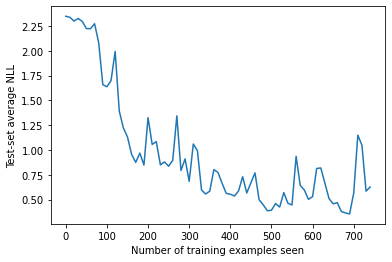

In [16]:
fig, ax = plt.subplots()
ax.plot(jnp.arange(0, 750, 10), orfit_test_nlls)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average NLL');

# 3. VDEKF

## 3.1 Hyperparameter Tuning

In [24]:
def vdekf_opt_fn(log_init_cov, log_dynamics_cov):
    vdekf_params = RebayesParams(
        initial_mean=flat_params,
        initial_covariance=jnp.ones(flat_params.shape[0]) * jnp.power(10, log_init_cov).item(),
        dynamics_weights=1.0,
        dynamics_covariance=jnp.ones((flat_params.size)) * jnp.power(10, log_dynamics_cov).item(),
        emission_mean_function=emission_mean_function,
        emission_cov_function=emission_cov_function,
    )
    vdekf_estimator = RebayesEKF(vdekf_params, 'vdekf')
    lls = []
    bel = vdekf_estimator.init_bel()
    for i in range(0, 701, 100):
        for j in range(i, i+100):
            bel = vdekf_estimator.predict_state(bel)
            bel = vdekf_estimator.update_state(bel, X_train[j], y_train_ohe[j])
        mean = bel.mean
        log_likelihood = -evaluate_neg_log_likelihood(mean, unflatten_fn, apply_fn, test_ds)
        lls.append(log_likelihood)

    return jnp.array(lls).mean()

In [25]:
vdekf_optimizer = BayesianOptimization(
    f=vdekf_opt_fn,
    pbounds={
        'log_init_cov': (-7.0, 0.0),
        'log_dynamics_cov': (-7.0, 0.0),
    }
)

In [27]:
vdekf_optimizer.maximize(
    init_points=100,
    n_iter=100,
)

|   iter    |  target   | log_dy... | log_in... |
-------------------------------------------------
| 13        | -0.9432   | -5.518    | -1.278    |
| 14        | -0.9428   | -6.02     | -1.332    |
| 15        | -6.125    | -2.524    | -2.176    |
| 16        | -0.8453   | -4.948    | -0.9708   |
| 17        | -1.215    | -2.758    | -0.9554   |
| 18        | -1.187    | -3.076    | -4.763    |
| 19        | -488.2    | -0.32     | -3.931    |
| 20        | -2.148    | -5.838    | -2.901    |
| 21        | -1.119    | -3.468    | -5.875    |
| 22        | -1.101    | -3.149    | -6.189    |
| 23        | -1.876    | -2.351    | -1.918    |
| 24        | -2.726    | -0.6749   | -3.292    |
| 25        | -2.256    | -5.651    | -6.771    |
| 26        | -2.263    | -5.723    | -6.803    |
| 27        | -0.908    | -5.16     | -1.108    |
| 28        | -1.976    | -5.034    | -4.602    |
| 29        | -1.484    | -6.026    | -2.279    |
| 30        | -1.043    | -4.433    | -1.683    |


KeyboardInterrupt: ignored

In [ ]:
# 'init_var': 0.19141313819543132
print(vdekf_optimizer.max)

{'target': -0.3926853537559509, 'params': {'init_var': 0.19141313819543132}}


## 3.2 Test-Set NLL Evaluation

In [ ]:
vdekf_init_var = 0.19141313819543132

vdekf_params = RebayesParams(
    initial_mean=flat_params,
    initial_covariance=jnp.ones(flat_params.shape[0]) * vdekf_init_var,
    dynamics_weights=None,
    dynamics_covariance=jnp.ones((flat_params.size)) * 1e-4,
    emission_mean_function=emission_mean_function,
    emission_cov_function=emission_cov_function,
)
vdekf_estimator = RebayesEKF(vdekf_params, 'vdekf')
vdekf_bel = vdekf_estimator.init_bel()

vdekf_test_nlls = []
for i in trange(750):
    vdekf_bel = vdekf_estimator.predict_state(vdekf_bel)
    vdekf_bel = vdekf_estimator.update_state(vdekf_bel, X_train[i], y_train_ohe[i])
    if i % 10 == 0:
        nll = evaluate_neg_log_likelihood(vdekf_bel.mean, unflatten_fn, apply_fn, test_ds)
        vdekf_test_nlls.append(nll)

vdekf_test_nlls = jnp.array(vdekf_test_nlls)

100%|██████████| 750/750 [00:31<00:00, 23.57it/s]


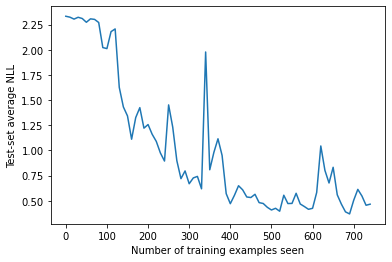

In [ ]:
fig, ax = plt.subplots()
ax.plot(jnp.arange(0, 750, 10), vdekf_test_nlls)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average NLL');

# 4. FDEKF

## 4.1 Hyperparameter Tuning

In [ ]:
def fdekf_opt_fn(log_init_cov, log_dynamics_cov):
    fdekf_params = RebayesParams(
        initial_mean=flat_params,
        initial_covariance=jnp.ones(flat_params.shape[0]) * jnp.power(10, log_init_cov).item(),
        dynamics_weights=1.0,
        dynamics_covariance=jnp.ones((flat_params.size)) * jnp.power(10, log_dynamics_cov).item(),
        emission_mean_function=emission_mean_function,
        emission_cov_function=emission_cov_function,
    )
    fdekf_estimator = RebayesEKF(fdekf_params, 'fdekf')
    lls = []
    bel = fdekf_estimator.init_bel()
    for i in range(0, 701, 100):
        for j in range(i, i+100):
            bel = fdekf_estimator.predict_state(bel)
            bel = fdekf_estimator.update_state(bel, X_train[j], y_train_ohe[j])
        mean = bel.mean
        log_likelihood = -evaluate_neg_log_likelihood(mean, unflatten_fn, apply_fn, test_ds)
        lls.append(log_likelihood)

    return jnp.array(lls).mean()

In [ ]:
fdekf_optimizer = BayesianOptimization(
    f=fdekf_opt_fn,
    pbounds={
        'log_init_cov': (-7.0, 0.0),
        'log_dynamics_cov': (-7.0, 0.0),
    }
)

In [ ]:
fdekf_optimizer.maximize(
    init_points=100,
    n_iter=100,
)

|   iter    |  target   | init_var  |
-------------------------------------


  0%|          | 0/750 [00:00<?, ?it/s]

| 1         | -2.313    | 0.8659    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 2         | -2.313    | 0.9586    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 3         | -2.312    | 0.623     |


  0%|          | 0/750 [00:00<?, ?it/s]

| 4         | -1.177    | 0.5536    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 5         | -0.7605   | 0.3992    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 6         | -0.7215   | 0.4857    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 7         | -2.312    | 0.7667    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 8         | -0.6602   | 0.1394    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 9         | -0.7596   | 0.05312   |


  0%|          | 0/750 [00:00<?, ?it/s]

| 10        | -0.8222   | 0.01275   |


  0%|          | 0/750 [00:00<?, ?it/s]

| 11        | -0.9154   | 0.498     |


  0%|          | 0/750 [00:00<?, ?it/s]

| 12        | -0.8208   | 0.09719   |


  0%|          | 0/750 [00:00<?, ?it/s]

| 13        | -0.5769   | 0.2966    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 14        | -0.7076   | 0.137     |


  0%|          | 0/750 [00:00<?, ?it/s]

| 15        | -2.312    | 0.5513    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 16        | -2.312    | 0.6737    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 17        | -2.313    | 0.833     |


  0%|          | 0/750 [00:00<?, ?it/s]

| 18        | -1.069    | 0.2292    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 19        | -0.6455   | 0.1234    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 20        | -0.8755   | 0.03881   |


  0%|          | 0/750 [00:00<?, ?it/s]

| 21        | -0.8448   | 0.4856    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 22        | -1.73     | 0.6158    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 23        | -0.7574   | 0.03709   |


  0%|          | 0/750 [00:00<?, ?it/s]

| 24        | -2.312    | 0.5462    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 25        | -0.7533   | 0.312     |


  0%|          | 0/750 [00:00<?, ?it/s]

| 26        | -0.9508   | 0.4699    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 27        | -0.6168   | 0.2151    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 28        | -2.313    | 0.9699    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 29        | -2.313    | 0.9464    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 30        | -0.9578   | 0.533     |


  0%|          | 0/750 [00:00<?, ?it/s]

| 31        | -2.312    | 0.7894    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 32        | -0.5068   | 0.205     |


  0%|          | 0/750 [00:00<?, ?it/s]

| 33        | -0.9898   | 0.5175    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 34        | -2.312    | 0.5879    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 35        | -2.312    | 0.8636    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 36        | -0.7148   | 0.4145    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 37        | -2.312    | 0.6219    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 38        | -2.312    | 0.7914    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 39        | -2.313    | 0.7958    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 40        | -0.8487   | 0.4114    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 41        | -2.313    | 0.8575    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 42        | -2.312    | 0.6803    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 43        | -2.313    | 0.8246    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 44        | -2.312    | 0.5755    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 45        | -2.313    | 0.7773    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 46        | -2.312    | 0.7439    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 47        | -0.9759   | 0.3168    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 48        | -2.313    | 0.9128    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 49        | -2.313    | 0.9152    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 50        | -2.313    | 0.9172    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 51        | -0.7304   | 0.4578    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 52        | -0.8296   | 0.5173    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 53        | -0.7059   | 0.3501    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 54        | -2.313    | 0.9277    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 55        | -0.7048   | 0.2297    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 56        | -2.312    | 0.9789    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 57        | -2.312    | 0.6624    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 58        | -2.313    | 0.8806    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 59        | -2.312    | 0.7342    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 60        | -0.6664   | 0.2812    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 61        | -0.9276   | 0.5288    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 62        | -1.192    | 0.459     |


  0%|          | 0/750 [00:00<?, ?it/s]

| 63        | -0.7852   | 0.06074   |


  0%|          | 0/750 [00:00<?, ?it/s]

| 64        | -2.312    | 0.6584    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 65        | -0.9386   | 0.2911    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 66        | -0.7092   | 0.3407    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 67        | -2.313    | 0.8543    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 68        | -2.313    | 0.9972    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 69        | -0.8462   | 0.01322   |


  0%|          | 0/750 [00:00<?, ?it/s]

| 70        | -2.312    | 0.6165    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 71        | -0.6754   | 0.4724    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 72        | -2.313    | 0.9766    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 73        | -2.312    | 0.6749    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 74        | -0.9607   | 0.2768    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 75        | -2.313    | 0.9573    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 76        | -0.8065   | 0.4403    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 77        | -0.8746   | 0.01232   |


  0%|          | 0/750 [00:00<?, ?it/s]

| 78        | -0.6658   | 0.3611    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 79        | -0.8274   | 0.03149   |


  0%|          | 0/750 [00:00<?, ?it/s]

| 80        | -2.312    | 0.7359    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 81        | -0.7555   | 0.4669    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 82        | -2.313    | 0.8122    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 83        | -0.7739   | 0.04652   |


  0%|          | 0/750 [00:00<?, ?it/s]

| 84        | -2.313    | 0.9146    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 85        | -0.7053   | 0.1563    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 86        | -0.6004   | 0.3095    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 87        | -2.312    | 0.6507    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 88        | -2.312    | 0.6452    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 89        | -2.312    | 0.7637    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 90        | -0.9126   | 0.5034    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 91        | -0.9874   | 0.6463    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 92        | -0.6505   | 0.3378    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 93        | -2.313    | 0.8706    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 94        | -0.8484   | 0.04925   |


  0%|          | 0/750 [00:00<?, ?it/s]

| 95        | -0.629    | 0.1963    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 96        | -0.7605   | 0.5098    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 97        | -2.312    | 0.6937    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 98        | -0.719    | 0.364     |


  0%|          | 0/750 [00:00<?, ?it/s]

| 99        | -2.313    | 0.9114    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 100       | -2.313    | 0.8754    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 101       | -1.174    | 0.5142    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 102       | -1.049    | 0.4858    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 103       | -0.6831   | 0.4857    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 104       | -0.7546   | 0.2966    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 105       | -0.7704   | 0.2152    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 106       | -0.6179   | 0.205     |


  0%|          | 0/750 [00:00<?, ?it/s]

| 107       | -0.792    | 0.3096    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 108       | -0.8414   | 0.1233    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 109       | -0.6327   | 0.1964    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 110       | -1.008    | 0.3379    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 111       | -1.188    | 0.2813    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 112       | -1.19     | 0.35      |


  0%|          | 0/750 [00:00<?, ?it/s]

| 113       | -0.7653   | 0.1393    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 114       | -1.099    | 0.3612    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 115       | -0.6657   | 0.2811    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 116       | -0.799    | 0.4144    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 117       | -1.167    | 0.4723    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 118       | -1.055    | 0.4725    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 119       | -0.7211   | 0.1564    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 120       | -0.7668   | 0.2965    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 121       | -1.061    | 0.2298    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 122       | -0.666    | 0.2052    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 123       | -0.7827   | 0.3405    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 124       | -0.8659   | 0.1369    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 125       | -0.625    | 0.361     |


  0%|          | 0/750 [00:00<?, ?it/s]

| 126       | -0.9642   | 0.3503    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 127       | -0.7216   | 0.3642    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 128       | -0.8056   | 0.2295    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 129       | -0.6555   | 0.3094    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 130       | -0.5462   | 0.1235    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 131       | -0.8339   | 0.3376    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 132       | -0.9072   | 0.01259   |


  0%|          | 0/750 [00:00<?, ?it/s]

| 133       | -0.8723   | 0.458     |


  0%|          | 0/750 [00:00<?, ?it/s]

| 134       | -1.036    | 0.3119    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 135       | -0.7049   | 0.1236    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 136       | -0.7419   | 0.05297   |


  0%|          | 0/750 [00:00<?, ?it/s]

| 137       | -0.6673   | 0.4671    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 138       | -0.8303   | 0.4854    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 139       | -0.9562   | 0.3994    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 140       | -0.5801   | 0.2149    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 141       | -0.7207   | 0.2148    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 142       | -0.7988   | 0.5097    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 143       | -0.831    | 0.03725   |


  0%|          | 0/750 [00:00<?, ?it/s]

| 144       | -0.8539   | 0.4672    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 145       | -0.7654   | 0.04669   |


  0%|          | 0/750 [00:00<?, ?it/s]

| 146       | -0.6111   | 0.3609    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 147       | -0.9025   | 0.3607    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 148       | -0.6843   | 0.1396    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 149       | -0.8302   | 0.06058   |


  0%|          | 0/750 [00:00<?, ?it/s]

| 150       | -0.6306   | 0.3122    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 151       | -0.8456   | 0.1397    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 152       | -0.8503   | 0.3123    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 153       | -0.6136   | 0.1372    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 154       | -0.7817   | 0.1373    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 155       | -0.8141   | 0.01304   |


  0%|          | 0/750 [00:00<?, ?it/s]

| 156       | -0.6233   | 0.1966    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 157       | -0.6228   | 0.1968    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 158       | -0.7618   | 0.1967    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 159       | -0.545    | 0.197     |


  0%|          | 0/750 [00:00<?, ?it/s]

| 160       | -1.001    | 0.4402    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 161       | -0.6533   | 0.1972    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 162       | -0.7458   | 0.1961    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 163       | -0.813    | 0.4147    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 164       | -0.7755   | 0.4577    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 165       | -0.798    | 0.3408    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 166       | -0.9132   | 0.1974    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 167       | -0.7691   | 0.3092    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 168       | -0.673    | 0.09699   |


  0%|          | 0/750 [00:00<?, ?it/s]

| 169       | -0.6087   | 0.09676   |


  0%|          | 0/750 [00:00<?, ?it/s]

| 170       | -0.6293   | 0.09656   |


  0%|          | 0/750 [00:00<?, ?it/s]

| 171       | -0.6125   | 0.09638   |


  0%|          | 0/750 [00:00<?, ?it/s]

| 172       | -0.6613   | 0.09625   |


  0%|          | 0/750 [00:00<?, ?it/s]

| 173       | -0.755    | 0.09606   |


  0%|          | 0/750 [00:00<?, ?it/s]

| 174       | -0.9821   | 0.399     |


  0%|          | 0/750 [00:00<?, ?it/s]

| 175       | -0.5815   | 0.2146    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 176       | -0.9712   | 0.2144    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 177       | -0.7903   | 0.09587   |


  0%|          | 0/750 [00:00<?, ?it/s]

| 178       | -0.5254   | 0.3638    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 179       | -0.6137   | 0.196     |


  0%|          | 0/750 [00:00<?, ?it/s]

| 180       | -0.995    | 0.3637    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 181       | -0.7036   | 0.1958    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 182       | -0.7271   | 0.1956    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 183       | -0.7443   | 0.1954    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 184       | -0.8613   | 0.03129   |


  0%|          | 0/750 [00:00<?, ?it/s]

| 185       | -0.8105   | 0.03688   |


  0%|          | 0/750 [00:00<?, ?it/s]

| 186       | -0.7853   | 0.2053    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 187       | -0.888    | 0.05277   |


  0%|          | 0/750 [00:00<?, ?it/s]

| 188       | -0.7633   | 0.1561    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 189       | -0.9673   | 0.3643    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 190       | -0.8386   | 0.1952    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 191       | -0.7409   | 0.1238    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 192       | -0.7017   | 0.1559    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 193       | -0.7522   | 0.1557    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 194       | -0.6745   | 0.1555    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 195       | -0.7893   | 0.1552    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 196       | -0.6616   | 0.124     |


  0%|          | 0/750 [00:00<?, ?it/s]

| 197       | -0.6365   | 0.1242    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 198       | -0.8467   | 0.1244    |


  0%|          | 0/750 [00:00<?, ?it/s]

| 199       | -0.6468   | 0.155     |


  0%|          | 0/750 [00:00<?, ?it/s]

| 200       | -0.7388   | 0.1548    |


In [ ]:
# 'init_var': 0.20503123904672077
print(fdekf_optimizer.max)

{'target': -0.506809651851654, 'params': {'init_var': 0.20503123904672077}}


## 4.2 Test-Set NLL Evaluation

In [ ]:
fdekf_init_var = 0.20503123904672077

fdekf_params = RebayesParams(
    initial_mean=flat_params,
    initial_covariance=jnp.ones(flat_params.shape[0]) * fdekf_init_var,
    dynamics_weights=None,
    dynamics_covariance=jnp.ones((flat_params.size)) * 1e-4,
    emission_mean_function=emission_mean_function,
    emission_cov_function=emission_cov_function,
)
fdekf_estimator = RebayesEKF(vdekf_params, 'fdekf')
fdekf_bel = fdekf_estimator.init_bel()

fdekf_test_nlls = []
for i in trange(750):
    fdekf_bel = fdekf_estimator.predict_state(fdekf_bel)
    fdekf_bel = fdekf_estimator.update_state(fdekf_bel, X_train[i], y_train_ohe[i])
    if i % 10 == 0:
        nll = evaluate_neg_log_likelihood(fdekf_bel.mean, unflatten_fn, apply_fn, test_ds)
        fdekf_test_nlls.append(nll)

fdekf_test_nlls = jnp.array(fdekf_test_nlls)

100%|██████████| 750/750 [00:31<00:00, 24.06it/s]


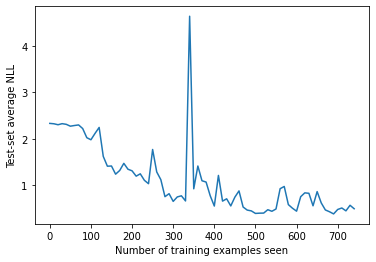

In [ ]:
fig, ax = plt.subplots()
ax.plot(jnp.arange(0, 750, 10), fdekf_test_nlls)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average NLL');

# 5. SGD

## 5.1 Hyperparameter Tuning

In [ ]:
@jit
def compute_loss_and_updates_sgd(state, batch_images, batch_labels):
    def loss_fn(params):
        logits = state.apply_fn(params, batch_images)
        loss = jnp.mean(optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=batch_labels))
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    return grads

In [ ]:
def train_model(state, X_train, y_train):
    @jit
    def apply_updates(state, updates):
        return state.apply_gradients(grads=updates)

    for i in trange(len(X_train)):
        curr_image = X_train[i].reshape(1,28,28,1)
        curr_label = y_train[i]

        updates = compute_loss_and_updates_sgd(state, curr_image, curr_label)
        state = apply_updates(state, updates)
    
    return state

In [ ]:
def sgd_opt_fn(lr, momentum):
    tx = optax.sgd(lr, momentum)
    opt_state = train_state.TrainState.create(apply_fn=apply_fn, params=flat_params, tx=tx)
    result_state = train_model(opt_state, X_train[:750], y_train[:750])
    mean = result_state.params
    log_likelihood = -evaluate_neg_log_likelihood(mean, unflatten_fn, apply_fn, test_ds)

    return log_likelihood

In [ ]:
sgd_optimizer = BayesianOptimization(
    f=sgd_opt_fn,
    pbounds={'lr': (1e-4, 1.0), 'momentum': (1e-4, 1.0)},
)

In [ ]:
sgd_optimizer.maximize(
    init_points=100,
    n_iter=100,
)

|   iter    |  target   |    lr     | momentum  |
-------------------------------------------------


100%|██████████| 750/750 [00:02<00:00, 288.25it/s]


| 1         | -7.591    | 0.7882    | 0.919     |


100%|██████████| 750/750 [00:02<00:00, 316.16it/s]


| 2         | -2.521    | 0.6745    | 0.1312    |


100%|██████████| 750/750 [00:02<00:00, 308.21it/s]


| 3         | -2.459    | 0.2269    | 0.4623    |


100%|██████████| 750/750 [00:02<00:00, 325.84it/s]


| 4         | -2.445    | 0.2764    | 0.2986    |


100%|██████████| 750/750 [00:02<00:00, 324.73it/s]


| 5         | -8.065    | 0.6324    | 0.9769    |


100%|██████████| 750/750 [00:02<00:00, 313.16it/s]


| 6         | -4.188    | 0.9994    | 0.7334    |


100%|██████████| 750/750 [00:02<00:00, 324.39it/s]


| 7         | -2.875    | 0.4023    | 0.7472    |


100%|██████████| 750/750 [00:02<00:00, 298.04it/s]


| 8         | -2.545    | 0.8923    | 0.03554   |


100%|██████████| 750/750 [00:02<00:00, 317.91it/s]


| 9         | -2.452    | 0.2422    | 0.4018    |


100%|██████████| 750/750 [00:02<00:00, 324.29it/s]


| 10        | -6.564    | 0.9995    | 0.8299    |


100%|██████████| 750/750 [00:02<00:00, 308.19it/s]


| 11        | -3.763    | 0.4587    | 0.8555    |


100%|██████████| 750/750 [00:02<00:00, 325.71it/s]


| 12        | -2.708    | 0.9943    | 0.3703    |


100%|██████████| 750/750 [00:02<00:00, 333.07it/s]


| 13        | -2.616    | 0.6465    | 0.4004    |


100%|██████████| 750/750 [00:02<00:00, 314.10it/s]


| 14        | -6.997    | 0.8214    | 0.8893    |


100%|██████████| 750/750 [00:02<00:00, 307.53it/s]


| 15        | -2.408    | 0.14      | 0.434     |


100%|██████████| 750/750 [00:02<00:00, 335.94it/s]


| 16        | -2.622    | 0.1372    | 0.8303    |


100%|██████████| 750/750 [00:02<00:00, 332.62it/s]


| 17        | -2.479    | 0.276     | 0.4591    |


100%|██████████| 750/750 [00:02<00:00, 318.62it/s]


| 18        | -4.619    | 0.6475    | 0.8422    |


100%|██████████| 750/750 [00:02<00:00, 317.24it/s]


| 19        | -2.56     | 0.2159    | 0.6984    |


100%|██████████| 750/750 [00:02<00:00, 314.03it/s]


| 20        | -3.484    | 0.2779    | 0.9147    |


100%|██████████| 750/750 [00:02<00:00, 319.79it/s]


| 21        | -2.546    | 0.9323    | 0.007455  |


100%|██████████| 750/750 [00:02<00:00, 318.77it/s]


| 22        | -10.85    | 0.3894    | 0.9792    |


100%|██████████| 750/750 [00:02<00:00, 328.46it/s]


| 23        | -2.556    | 0.2579    | 0.6516    |


100%|██████████| 750/750 [00:02<00:00, 315.68it/s]


| 24        | -2.676    | 0.9502    | 0.3386    |


100%|██████████| 750/750 [00:02<00:00, 312.73it/s]


| 25        | -4.337    | 0.8103    | 0.7795    |


100%|██████████| 750/750 [00:02<00:00, 316.06it/s]


| 26        | -2.518    | 0.5193    | 0.2868    |


100%|██████████| 750/750 [00:02<00:00, 336.00it/s]


| 27        | -2.445    | 0.1298    | 0.6077    |


100%|██████████| 750/750 [00:02<00:00, 312.73it/s]


| 28        | -1.967    | 0.1486    | 0.183     |


100%|██████████| 750/750 [00:02<00:00, 308.61it/s]


| 29        | -2.649    | 0.4466    | 0.5903    |


100%|██████████| 750/750 [00:02<00:00, 333.71it/s]


| 30        | -2.415    | 0.139     | 0.3219    |


100%|██████████| 750/750 [00:02<00:00, 321.35it/s]


| 31        | -2.503    | 0.6867    | 0.02461   |


100%|██████████| 750/750 [00:02<00:00, 308.87it/s]


| 32        | -2.961    | 0.2291    | 0.8813    |


100%|██████████| 750/750 [00:02<00:00, 318.51it/s]


| 33        | -2.579    | 0.1659    | 0.7693    |


100%|██████████| 750/750 [00:02<00:00, 305.84it/s]


| 34        | -2.543    | 0.6681    | 0.2228    |


100%|██████████| 750/750 [00:02<00:00, 329.10it/s]


| 35        | -3.84     | 0.555     | 0.823     |


100%|██████████| 750/750 [00:02<00:00, 331.84it/s]


| 36        | -2.481    | 0.3019    | 0.4262    |


100%|██████████| 750/750 [00:02<00:00, 307.59it/s]


| 37        | -2.453    | 0.3525    | 0.1949    |


100%|██████████| 750/750 [00:02<00:00, 320.73it/s]


| 38        | -2.514    | 0.6917    | 0.07828   |


100%|██████████| 750/750 [00:02<00:00, 328.61it/s]


| 39        | -2.529    | 0.645     | 0.1952    |


100%|██████████| 750/750 [00:02<00:00, 329.21it/s]


| 40        | -2.553    | 0.8155    | 0.1332    |


100%|██████████| 750/750 [00:02<00:00, 321.90it/s]


| 41        | -2.565    | 0.1859    | 0.7343    |


100%|██████████| 750/750 [00:02<00:00, 327.21it/s]


| 42        | -2.518    | 0.4078    | 0.415     |


100%|██████████| 750/750 [00:02<00:00, 327.20it/s]


| 43        | -7.313    | 0.6747    | 0.9455    |


100%|██████████| 750/750 [00:02<00:00, 319.76it/s]


| 44        | -4.076    | 0.7787    | 0.7688    |


100%|██████████| 750/750 [00:02<00:00, 316.65it/s]


| 45        | -1.644    | 0.1219    | 0.1966    |


100%|██████████| 750/750 [00:02<00:00, 323.06it/s]


| 46        | -5.617    | 0.9145    | 0.8169    |


100%|██████████| 750/750 [00:02<00:00, 337.01it/s]


| 47        | -0.7555   | 0.06337   | 0.3301    |


100%|██████████| 750/750 [00:02<00:00, 308.02it/s]


| 48        | -2.46     | 0.3133    | 0.3142    |


100%|██████████| 750/750 [00:02<00:00, 318.48it/s]


| 49        | -2.43     | 0.1089    | 0.6185    |


100%|██████████| 750/750 [00:02<00:00, 314.58it/s]


| 50        | -13.95    | 0.7431    | 0.9789    |


100%|██████████| 750/750 [00:02<00:00, 329.57it/s]


| 51        | -1.576    | 0.1318    | 0.2305    |


100%|██████████| 750/750 [00:02<00:00, 318.34it/s]


| 52        | -0.6168   | 0.04173   | 0.111     |


100%|██████████| 750/750 [00:02<00:00, 309.63it/s]


| 53        | -2.504    | 0.525     | 0.2238    |


100%|██████████| 750/750 [00:02<00:00, 317.52it/s]


| 54        | -3.153    | 0.8169    | 0.6416    |


100%|██████████| 750/750 [00:02<00:00, 319.54it/s]


| 55        | -2.463    | 0.3573    | 0.2562    |


100%|██████████| 750/750 [00:02<00:00, 324.81it/s]


| 56        | -0.6769   | 0.06066   | 0.356     |


100%|██████████| 750/750 [00:02<00:00, 321.82it/s]


| 57        | -5.415    | 0.863     | 0.8199    |


100%|██████████| 750/750 [00:02<00:00, 318.82it/s]


| 58        | -47.19    | 0.909     | 0.9925    |


100%|██████████| 750/750 [00:02<00:00, 308.70it/s]


| 59        | -2.705    | 0.5393    | 0.5697    |


100%|██████████| 750/750 [00:02<00:00, 330.54it/s]


| 60        | -0.9221   | 0.006743  | 0.1581    |


100%|██████████| 750/750 [00:02<00:00, 317.51it/s]


| 61        | -2.568    | 0.9586    | 0.08398   |


100%|██████████| 750/750 [00:02<00:00, 323.98it/s]


| 62        | -2.913    | 0.5964    | 0.6469    |


100%|██████████| 750/750 [00:02<00:00, 297.34it/s]


| 63        | -2.498    | 0.3617    | 0.4087    |


100%|██████████| 750/750 [00:02<00:00, 324.19it/s]


| 64        | -2.856    | 0.7318    | 0.5634    |


100%|██████████| 750/750 [00:02<00:00, 322.46it/s]


| 65        | -2.723    | 0.8814    | 0.4167    |


100%|██████████| 750/750 [00:02<00:00, 322.16it/s]


| 66        | -3.568    | 0.6492    | 0.7591    |


100%|██████████| 750/750 [00:02<00:00, 308.55it/s]


| 67        | -2.596    | 0.7544    | 0.2919    |


100%|██████████| 750/750 [00:02<00:00, 327.70it/s]


| 68        | -2.705    | 0.6724    | 0.4885    |


100%|██████████| 750/750 [00:02<00:00, 315.07it/s]


| 69        | -3.821    | 0.775     | 0.748     |


100%|██████████| 750/750 [00:02<00:00, 329.44it/s]


| 70        | -2.415    | 0.1551    | 0.3891    |


100%|██████████| 750/750 [00:02<00:00, 327.52it/s]


| 71        | -2.395    | 0.1954    | 0.1221    |


100%|██████████| 750/750 [00:02<00:00, 310.52it/s]


| 72        | -2.492    | 0.615     | 0.04712   |


100%|██████████| 750/750 [00:02<00:00, 320.56it/s]


| 73        | -2.451    | 0.02438   | 0.9273    |


100%|██████████| 750/750 [00:02<00:00, 326.67it/s]


| 74        | -2.77     | 0.1876    | 0.8586    |


100%|██████████| 750/750 [00:02<00:00, 313.96it/s]


| 75        | -2.69     | 0.8318    | 0.3987    |


100%|██████████| 750/750 [00:02<00:00, 310.70it/s]


| 76        | -3.548    | 0.8694    | 0.6973    |


100%|██████████| 750/750 [00:02<00:00, 322.16it/s]


| 77        | -2.473    | 0.5416    | 0.0153    |


100%|██████████| 750/750 [00:02<00:00, 323.29it/s]


| 78        | -2.484    | 0.6001    | 0.009983  |


100%|██████████| 750/750 [00:02<00:00, 308.09it/s]


| 79        | -11.82    | 0.5938    | 0.9598    |


100%|██████████| 750/750 [00:02<00:00, 307.12it/s]


| 80        | -2.966    | 0.6299    | 0.6501    |


100%|██████████| 750/750 [00:02<00:00, 322.54it/s]


| 81        | -3.762    | 0.9148    | 0.7125    |


100%|██████████| 750/750 [00:02<00:00, 330.83it/s]


| 82        | -1.003    | 0.003051  | 0.4445    |


100%|██████████| 750/750 [00:02<00:00, 326.18it/s]


| 83        | -2.503    | 0.3362    | 0.456     |


100%|██████████| 750/750 [00:02<00:00, 324.35it/s]


| 84        | -2.852    | 0.5408    | 0.6523    |


100%|██████████| 750/750 [00:02<00:00, 311.07it/s]


| 85        | -2.611    | 0.9119    | 0.2382    |


100%|██████████| 750/750 [00:02<00:00, 317.64it/s]


| 86        | -2.442    | 0.3184    | 0.1889    |


100%|██████████| 750/750 [00:02<00:00, 319.27it/s]


| 87        | -1.22     | 0.06244   | 0.5476    |


100%|██████████| 750/750 [00:02<00:00, 325.04it/s]


| 88        | -2.862    | 0.817     | 0.5387    |


100%|██████████| 750/750 [00:02<00:00, 316.14it/s]


| 89        | -2.614    | 0.4529    | 0.548     |


100%|██████████| 750/750 [00:02<00:00, 321.89it/s]


| 90        | -2.564    | 0.6234    | 0.3185    |


100%|██████████| 750/750 [00:02<00:00, 318.30it/s]


| 91        | -3.16     | 0.6135    | 0.7084    |


100%|██████████| 750/750 [00:02<00:00, 325.38it/s]


| 92        | -2.48     | 0.378     | 0.313     |


100%|██████████| 750/750 [00:02<00:00, 324.68it/s]


| 93        | -2.592    | 0.8797    | 0.209     |


100%|██████████| 750/750 [00:02<00:00, 314.78it/s]


| 94        | -3.043    | 0.8102    | 0.6133    |


100%|██████████| 750/750 [00:02<00:00, 317.50it/s]


| 95        | -2.777    | 0.531     | 0.622     |


100%|██████████| 750/750 [00:02<00:00, 324.26it/s]


| 96        | -2.536    | 0.8114    | 0.06697   |


100%|██████████| 750/750 [00:02<00:00, 324.99it/s]


| 97        | -7.179    | 0.8958    | 0.8772    |


100%|██████████| 750/750 [00:02<00:00, 308.81it/s]


| 98        | -2.846    | 0.6073    | 0.6135    |


100%|██████████| 750/750 [00:02<00:00, 329.30it/s]


| 99        | -2.598    | 0.8453    | 0.2426    |


100%|██████████| 750/750 [00:02<00:00, 316.74it/s]


| 100       | -2.682    | 0.714     | 0.4436    |


100%|██████████| 750/750 [00:02<00:00, 330.14it/s]


| 101       | -2.29     | 0.0001    | 0.0001    |


100%|██████████| 750/750 [00:02<00:00, 304.55it/s]


| 102       | -2.387    | 0.1175    | 0.3919    |


100%|██████████| 750/750 [00:02<00:00, 318.91it/s]


| 103       | -2.876    | 0.9008    | 0.5253    |


100%|██████████| 750/750 [00:02<00:00, 317.83it/s]


| 104       | -0.7853   | 0.0618    | 0.3255    |


100%|██████████| 750/750 [00:02<00:00, 321.54it/s]


| 105       | -2.428    | 0.3392    | 0.002474  |


100%|██████████| 750/750 [00:02<00:00, 323.54it/s]


| 106       | -1.063    | 0.001276  | 0.7322    |


100%|██████████| 750/750 [00:02<00:00, 327.17it/s]


| 107       | -1.556    | 0.1474    | 0.004009  |


100%|██████████| 750/750 [00:02<00:00, 331.96it/s]


| 108       | -26.61    | 0.1449    | 1.0       |


100%|██████████| 750/750 [00:02<00:00, 319.05it/s]


| 109       | -0.8335   | 0.003022  | 0.8436    |


100%|██████████| 750/750 [00:02<00:00, 319.44it/s]


| 110       | -2.882    | 0.3059    | 0.8143    |


100%|██████████| 750/750 [00:02<00:00, 315.77it/s]


| 111       | -3.042    | 0.9995    | 0.5789    |


100%|██████████| 750/750 [00:02<00:00, 315.19it/s]


| 112       | -1.369    | 0.001229  | 0.6075    |


100%|██████████| 750/750 [00:02<00:00, 314.55it/s]


| 113       | -2.46     | 0.4351    | 0.0941    |


100%|██████████| 750/750 [00:02<00:00, 319.73it/s]


| 114       | -2.616    | 0.9996    | 0.2103    |


100%|██████████| 750/750 [00:02<00:00, 304.36it/s]


| 115       | -4.562    | 0.4686    | 0.9328    |


100%|██████████| 750/750 [00:02<00:00, 327.30it/s]


| 116       | -2.579    | 0.5337    | 0.4277    |


100%|██████████| 750/750 [00:02<00:00, 329.16it/s]


| 117       | -2.404    | 0.2487    | 0.01133   |


100%|██████████| 750/750 [00:02<00:00, 320.62it/s]


| 118       | -1.328    | 0.002372  | 0.251     |


100%|██████████| 750/750 [00:02<00:00, 303.38it/s]


| 119       | -2.526    | 0.5138    | 0.32      |


100%|██████████| 750/750 [00:02<00:00, 319.20it/s]


| 120       | -2.283    | 0.0001    | 0.3507    |


100%|██████████| 750/750 [00:02<00:00, 316.74it/s]


| 121       | -2.561    | 0.342     | 0.5763    |


100%|██████████| 750/750 [00:02<00:00, 325.74it/s]


| 122       | -2.487    | 0.5256    | 0.1379    |


100%|██████████| 750/750 [00:02<00:00, 331.41it/s]


| 123       | -2.824    | 0.9909    | 0.4772    |


100%|██████████| 750/750 [00:02<00:00, 328.87it/s]


| 124       | -2.453    | 0.4554    | 0.0004445 |


100%|██████████| 750/750 [00:02<00:00, 329.42it/s]


| 125       | -2.555    | 1.0       | 0.0001    |


100%|██████████| 750/750 [00:02<00:00, 322.42it/s]


| 126       | -1.056    | 0.002278  | 0.5258    |


100%|██████████| 750/750 [00:02<00:00, 310.23it/s]


| 127       | -0.7302   | 0.09895   | 0.06272   |


100%|██████████| 750/750 [00:02<00:00, 321.79it/s]


| 128       | -2.431    | 0.3181    | 0.08977   |


100%|██████████| 750/750 [00:02<00:00, 323.49it/s]


| 129       | -2.436    | 0.0723    | 0.7412    |


100%|██████████| 750/750 [00:02<00:00, 315.76it/s]


| 130       | -2.519    | 0.7892    | 0.0001    |


100%|██████████| 750/750 [00:02<00:00, 324.83it/s]


| 131       | -2.032    | 0.001456  | 0.08036   |


100%|██████████| 750/750 [00:02<00:00, 329.89it/s]


| 132       | -2.663    | 0.3546    | 0.677     |


100%|██████████| 750/750 [00:02<00:00, 325.46it/s]


| 133       | -0.625    | 0.07346   | 0.0001    |


100%|██████████| 750/750 [00:02<00:00, 326.63it/s]


| 134       | -2.173    | 0.0001    | 0.8978    |


100%|██████████| 750/750 [00:02<00:00, 311.02it/s]


| 135       | -1.985    | 0.1575    | 0.06239   |


100%|██████████| 750/750 [00:02<00:00, 325.72it/s]


| 136       | -2.498    | 0.4902    | 0.2411    |


100%|██████████| 750/750 [00:02<00:00, 328.94it/s]


| 137       | -2.49     | 0.2304    | 0.5568    |


100%|██████████| 750/750 [00:02<00:00, 319.66it/s]


| 138       | -3.078    | 0.4965    | 0.7463    |


100%|██████████| 750/750 [00:02<00:00, 318.97it/s]


| 139       | -2.447    | 0.05153   | 0.8277    |


100%|██████████| 750/750 [00:02<00:00, 313.59it/s]


| 140       | -0.6613   | 0.05961   | 0.2902    |


100%|██████████| 750/750 [00:02<00:00, 334.66it/s]


| 141       | -0.637    | 0.05142   | 0.2082    |


100%|██████████| 750/750 [00:02<00:00, 309.16it/s]


| 142       | -2.718    | 0.4761    | 0.6223    |


100%|██████████| 750/750 [00:02<00:00, 325.41it/s]


| 143       | -0.7224   | 0.0563    | 0.4778    |


100%|██████████| 750/750 [00:02<00:00, 323.32it/s]


| 144       | -3.15     | 0.9238    | 0.6198    |


100%|██████████| 750/750 [00:02<00:00, 334.01it/s]


| 145       | -0.8296   | 0.0001    | 0.9994    |


100%|██████████| 750/750 [00:02<00:00, 323.91it/s]


| 146       | -0.8237   | 0.003716  | 0.7805    |


100%|██████████| 750/750 [00:02<00:00, 309.15it/s]


| 147       | -2.518    | 0.7111    | 0.07823   |


100%|██████████| 750/750 [00:02<00:00, 320.60it/s]


| 148       | -2.557    | 0.7539    | 0.1932    |


100%|██████████| 750/750 [00:02<00:00, 318.84it/s]


| 149       | -2.706    | 0.2334    | 0.7997    |


100%|██████████| 750/750 [00:02<00:00, 317.18it/s]


| 150       | -2.559    | 0.966     | 0.04371   |


100%|██████████| 750/750 [00:02<00:00, 328.36it/s]


| 151       | -2.423    | 0.1345    | 0.5195    |


100%|██████████| 750/750 [00:02<00:00, 328.15it/s]


| 152       | -2.654    | 0.9992    | 0.2893    |


100%|██████████| 750/750 [00:02<00:00, 330.57it/s]


| 153       | -1.254    | 0.09856   | 0.125     |


100%|██████████| 750/750 [00:02<00:00, 330.07it/s]


| 154       | -2.417    | 0.2281    | 0.2184    |


100%|██████████| 750/750 [00:02<00:00, 328.64it/s]


| 155       | -0.8572   | 0.003389  | 0.6699    |


100%|██████████| 750/750 [00:02<00:00, 306.54it/s]


| 156       | -2.565    | 0.186     | 0.7342    |


100%|██████████| 750/750 [00:02<00:00, 312.47it/s]


| 157       | -3.425    | 0.3486    | 0.8748    |


100%|██████████| 750/750 [00:02<00:00, 317.52it/s]


| 158       | -2.658    | 0.59      | 0.4923    |


100%|██████████| 750/750 [00:02<00:00, 318.67it/s]


| 159       | -0.6725   | 0.05325   | 0.04539   |


100%|██████████| 750/750 [00:02<00:00, 322.67it/s]


| 160       | -2.613    | 0.7104    | 0.3535    |


100%|██████████| 750/750 [00:02<00:00, 323.44it/s]


| 161       | -0.9073   | 0.09834   | 0.1252    |


100%|██████████| 750/750 [00:02<00:00, 320.27it/s]


| 162       | -0.7686   | 0.09564   | 0.135     |


100%|██████████| 750/750 [00:02<00:00, 318.83it/s]


| 163       | -0.5422   | 0.0851    | 0.127     |


100%|██████████| 750/750 [00:02<00:00, 312.51it/s]


| 164       | -0.6672   | 0.04898   | 0.3431    |


100%|██████████| 750/750 [00:02<00:00, 310.14it/s]


| 165       | -0.5602   | 0.04413   | 0.3247    |


100%|██████████| 750/750 [00:02<00:00, 328.06it/s]


| 166       | -0.7648   | 0.0585    | 0.3062    |


100%|██████████| 750/750 [00:02<00:00, 317.11it/s]


| 167       | -0.5609   | 0.04372   | 0.2991    |


100%|██████████| 750/750 [00:02<00:00, 323.34it/s]


| 168       | -0.6693   | 0.07014   | 0.04875   |


100%|██████████| 750/750 [00:02<00:00, 324.25it/s]


| 169       | -0.7846   | 0.082     | 0.06761   |


100%|██████████| 750/750 [00:02<00:00, 317.79it/s]


| 170       | -0.5439   | 0.0609    | 0.06485   |


100%|██████████| 750/750 [00:02<00:00, 312.68it/s]


| 171       | -1.021    | 0.08926   | 0.04776   |


100%|██████████| 750/750 [00:02<00:00, 300.34it/s]


| 172       | -0.6302   | 0.06443   | 0.018     |


100%|██████████| 750/750 [00:02<00:00, 302.52it/s]


| 173       | -0.6082   | 0.05438   | 0.001811  |


100%|██████████| 750/750 [00:02<00:00, 310.95it/s]


| 174       | -0.5921   | 0.04354   | 0.0179    |


100%|██████████| 750/750 [00:02<00:00, 315.35it/s]


| 175       | -2.468    | 0.3649    | 0.2691    |


100%|██████████| 750/750 [00:02<00:00, 320.23it/s]


| 176       | -0.6295   | 0.08394   | 0.02219   |


100%|██████████| 750/750 [00:02<00:00, 288.32it/s]


| 177       | -0.5792   | 0.05191   | 0.08646   |


100%|██████████| 750/750 [00:02<00:00, 317.01it/s]


| 178       | -2.423    | 0.1346    | 0.5192    |


100%|██████████| 750/750 [00:02<00:00, 310.81it/s]


| 179       | -2.611    | 0.9699    | 0.2117    |


100%|██████████| 750/750 [00:02<00:00, 328.44it/s]


| 180       | -0.7043   | 0.07564   | 0.09231   |


100%|██████████| 750/750 [00:02<00:00, 310.12it/s]


| 181       | -0.6868   | 0.0254    | 0.09274   |


100%|██████████| 750/750 [00:02<00:00, 321.95it/s]


| 182       | -0.5808   | 0.03709   | 0.07269   |


100%|██████████| 750/750 [00:02<00:00, 312.84it/s]


| 183       | -2.61     | 0.9301    | 0.2256    |


100%|██████████| 750/750 [00:02<00:00, 312.98it/s]


| 184       | -0.7087   | 0.02323   | 0.401     |


100%|██████████| 750/750 [00:02<00:00, 309.98it/s]


| 185       | -0.6446   | 0.02181   | 0.423     |


100%|██████████| 750/750 [00:02<00:00, 312.58it/s]


| 186       | -1.029    | 0.002809  | 0.4128    |


100%|██████████| 750/750 [00:02<00:00, 318.45it/s]


| 187       | -0.8809   | 0.002645  | 0.7569    |


100%|██████████| 750/750 [00:02<00:00, 315.67it/s]


| 188       | -0.6909   | 0.01943   | 0.1238    |


100%|██████████| 750/750 [00:02<00:00, 303.95it/s]


| 189       | -0.6584   | 0.03574   | 0.1392    |


100%|██████████| 750/750 [00:02<00:00, 317.50it/s]


| 190       | -0.6164   | 0.03029   | 0.04231   |


100%|██████████| 750/750 [00:02<00:00, 327.81it/s]


| 191       | -0.6997   | 0.0233    | 0.4011    |


100%|██████████| 750/750 [00:02<00:00, 305.64it/s]


| 192       | -0.6313   | 0.03458   | 0.1662    |


100%|██████████| 750/750 [00:02<00:00, 297.75it/s]


| 193       | -2.519    | 0.5839    | 0.2185    |


100%|██████████| 750/750 [00:02<00:00, 309.92it/s]


| 194       | -0.6168   | 0.0328    | 0.1911    |


100%|██████████| 750/750 [00:02<00:00, 295.94it/s]


| 195       | -2.537    | 0.819     | 0.06638   |


100%|██████████| 750/750 [00:02<00:00, 291.10it/s]


| 196       | -4.243    | 0.9946    | 0.7378    |


100%|██████████| 750/750 [00:02<00:00, 301.09it/s]


| 197       | -2.867    | 0.3988    | 0.7469    |


100%|██████████| 750/750 [00:02<00:00, 320.27it/s]


| 198       | -0.6905   | 0.02128   | 0.2153    |


100%|██████████| 750/750 [00:02<00:00, 321.72it/s]


| 199       | -1.016    | 0.004108  | 0.1908    |


100%|██████████| 750/750 [00:02<00:00, 307.46it/s]


| 200       | -0.5904   | 0.03071   | 0.4548    |


In [ ]:
# 'lr': 0.08510103772846885, 'momentum': 0.127006538147039}
print(sgd_optimizer.max)

{'target': -0.5422303676605225, 'params': {'lr': 0.08510103772846885, 'momentum': 0.127006538147039}}


## 5.2 Test-Set NLL Evaluation

In [ ]:
def train_and_evaluate_model(state, X_train, y_train):
    @jit
    def apply_updates(state, updates):
        return state.apply_gradients(grads=updates)

    nlls = []
    for i in trange(len(X_train)):
        curr_image = X_train[i].reshape(1,28,28,1)
        curr_label = y_train[i]

        updates = compute_loss_and_updates_sgd(state, curr_image, curr_label)
        state = apply_updates(state, updates)
        if i % 10 == 0:
            nll = evaluate_neg_log_likelihood(state.params, unflatten_fn, apply_fn, test_ds)
            nlls.append(nll)
    
    return state, jnp.array(nlls)

In [ ]:
sgd_lr = 0.08510103772846885
sgd_momentum = 0.127006538147039

tx = optax.sgd(sgd_lr, sgd_momentum)
opt_state = train_state.TrainState.create(apply_fn=apply_fn, params=flat_params, tx=tx)

_, sgd_test_nlls = train_and_evaluate_model(opt_state, X_train[:750], y_train[:750])

100%|██████████| 750/750 [00:30<00:00, 24.86it/s]


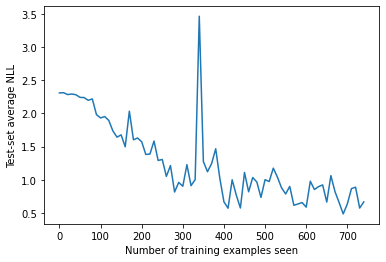

In [ ]:
fig, ax = plt.subplots()
ax.plot(jnp.arange(0, 750, 10), sgd_test_nlls)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average NLL');

# 6 Model Comparison

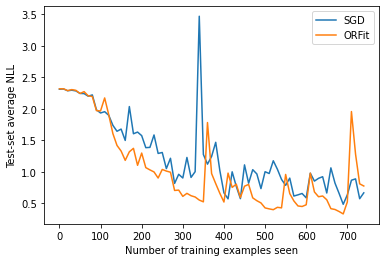

In [ ]:
fig, ax = plt.subplots()
ax.plot(jnp.arange(0, 750, 10), sgd_test_nlls, label='SGD')
# ax.plot(jnp.arange(0, 750, 10), vdekf_test_nlls, label='VDEKF')
# ax.plot(jnp.arange(0, 750, 10), fdekf_test_nlls, label='FDEKF')
ax.plot(jnp.arange(0, 750, 10), orfit_test_nlls, label='ORFit')
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average NLL')
ax.legend();